In [1]:
#== Import required libraries ==#
using Catlab.Graphs
using Catlab.Graphics
using Catlab.CategoricalAlgebra
using CombinatorialSpaces
using Distributions
using CairoMakie
using DifferentialEquations
using AlgebraicDynamics.TontiDiagrams

In [2]:
# helper function for setting initial conditions
function gen_form(s::EmbeddedDeltaSet2D, f::Function)
  map(f, point(s))
end

gen_form (generic function with 1 method)

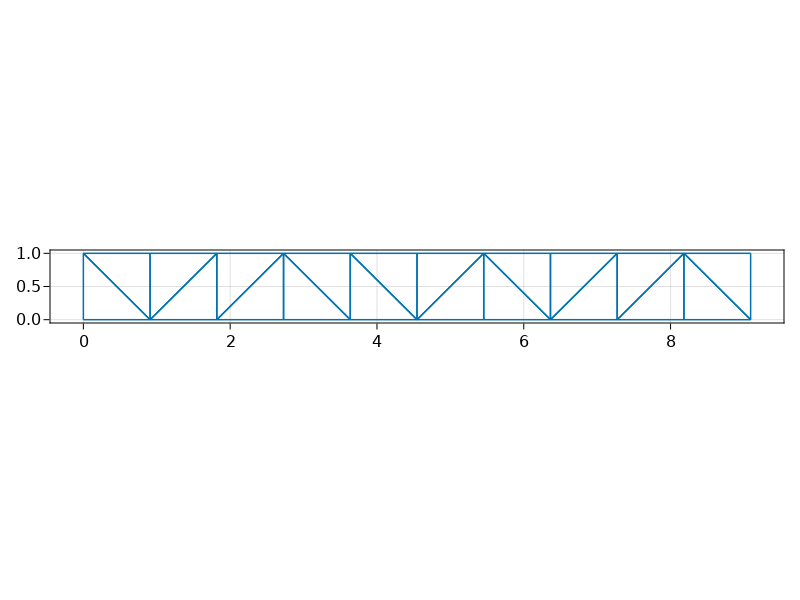

In [3]:
s = EmbeddedDeltaSet2D("truss_v1.obj");
sp = Space(s)
sd = sp.sd;
figure, axis, ob = wireframe(s)
axis.aspect = AxisAspect(10/1)
figure

In [5]:
# Get boundary masks for BCs #
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s))) # mesh edges
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt])) # mesh edge vertices

# Define vertices for BC application 
left = filter(x->all((0.0,0.0,0.0) .<= s[x,:point] .<= (0.0,1.0,0.0)), boundary_v) # fixed end
load_v = [22]; # free end load application point

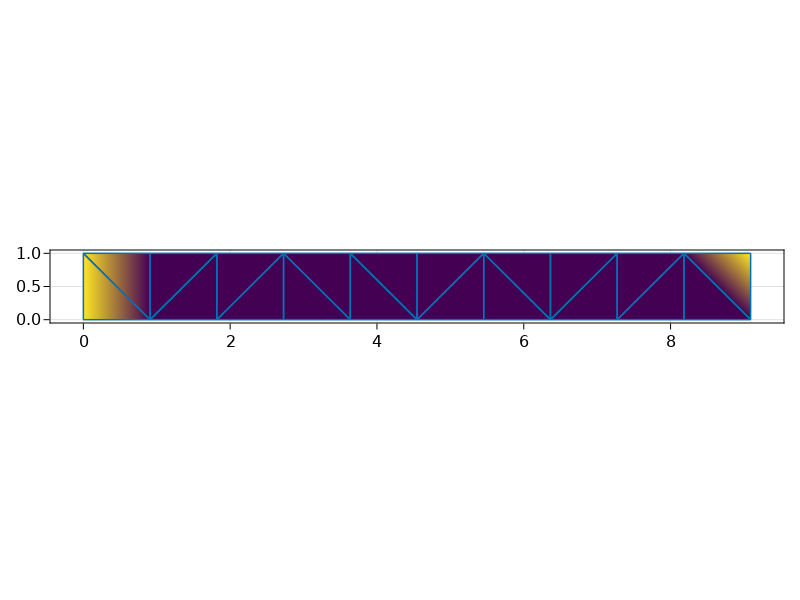

In [6]:
boundary_indices = [1, 2, 22]
colors = zeros(nv(s)) # Generate a 0-form (array with the same number of elements as there are points
colors[boundary_indices] .= 1 # "highlight" the boundary vertices
fig, ax, ob = mesh(s, color=colors)
wireframe!(s)
ax.aspect = AxisAspect(10/1)
fig

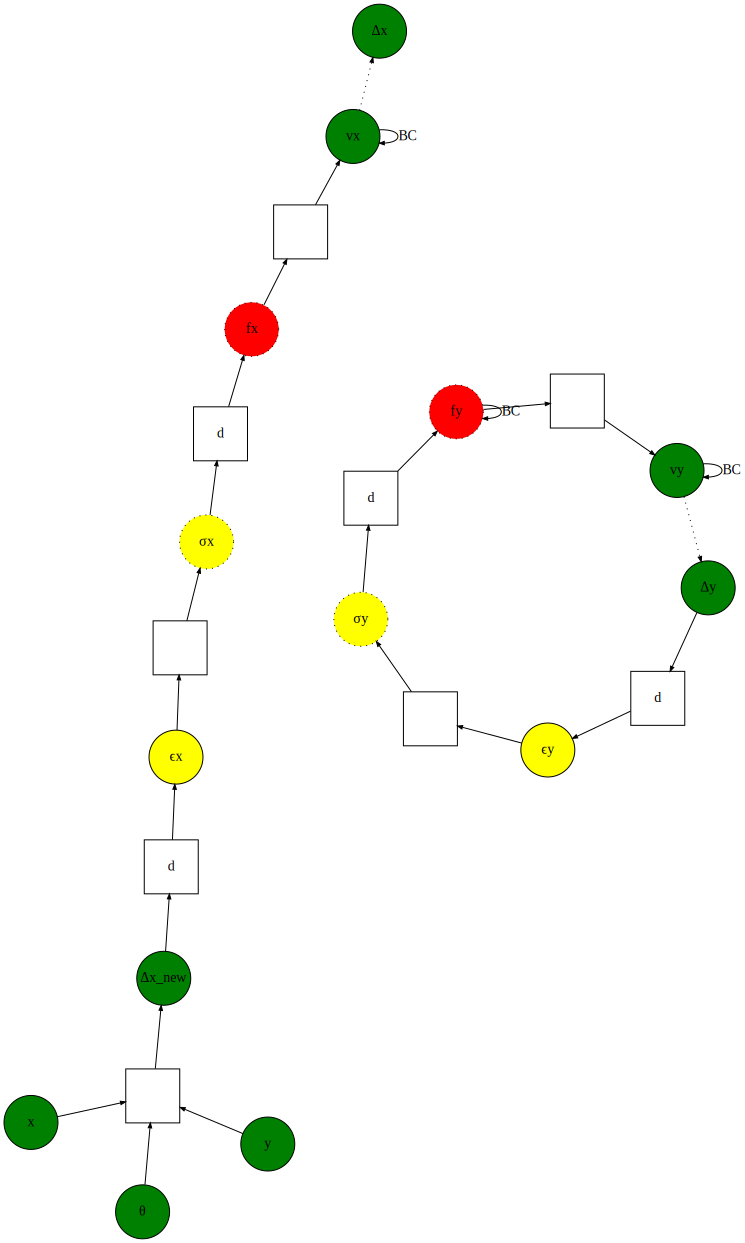

In [93]:
tdx = TontiDiagram();
tdy = TontiDiagram();

# Define the physical constants
F_load = -9 * 10^6 # prescribed free end point force (N)
E = 5 * 10^6 # Elastic Young's modulus (N/m^2)
A = 1; # cross-sectional area (m^2)
x0 = 10; # original length (m)
d = 0.025;
I = 1/12;

# Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
add_variables!(tdx, (:x,0,true), (:Δx,0,true), (:Δx_new,0,true), (:ϵx,1,true),(:σx,1,false), (:fx,2,false), (:vx, 0, true))
add_variables!(tdy, (:y,0,true), (:Δy,0,true), (:θ,0,true), (:ϵy,1,true),(:σy,1,false), (:fy,2,false), (:vy, 0, true))

# Add spatial and temporal derivative relationships
add_derivatives!(tdx, sp, :σx=>:fx)
add_derivatives!(tdy, sp, :σy=>:fy)
add_time_dep!(tdx, :vx, :Δx)
add_time_dep!(tdy, :vy, :Δy)

# Merge the two diagrams to allow Hooke's law to be defined
td = disjoint_union(tdx, tdy);

# Deal with coupled displacements
add_transition!(td, [:x, :y, :θ], (Δx_new, x, y, θ) -> begin
        θ .= ((F_load .*x)./(2*E*I)).*(2*x0 .- x)
        Δx_new .= -y.*(θ)
    end, [:Δx_new])


add_derivatives!(td, sp, :Δx_new=>:ϵx)
add_derivatives!(td, sp, :Δy=>:ϵy)

# Dual-primal mesh relationships
add_transition!(td, [:ϵx], (σx,ϵx) -> (σx.=E*sp.hodge[1,2]*ϵx) , [:σx])
add_transition!(td, [:ϵy], (σy,ϵy) -> (σy.=E*sp.hodge[1,2]*ϵy) , [:σy])
add_transition!(td, [:fx], (vx,fx) -> (vx.=d*sp.hodge[2,3]*(fx)), [:vx])
add_transition!(td, [:fy], (vy,fy) -> (vy.=d*sp.hodge[2,3]*(fy)), [:vy])

# Boundary conditions for a fixed-free configuration
add_bc!(td, :vx, Δx->(Δx[vcat(left)].=0))
add_bc!(td, :vy, Δy->(Δy[vcat(left)].=0))
add_bc!(td, :fy, (fy)->(fy[load_v] .+= F_load))
to_graphviz(td)

In [86]:
# tdx = TontiDiagram();
# tdy = TontiDiagram();

# # Define the physical constants
# F_load = -9 * 10^6 # prescribed free end point force (N)
# E = 5 * 10^6 # Elastic Young's modulus (N/m^2)
# A = 1; # cross-sectional area (m^2)
# x0 = 10; # original length (m)
# d = 0.025;
# # 

# # # Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
# # add_variables!(tdx, (:x,0,true), (:u,0,true), (:∂x, 1, true), (:u_new,0,true), (:ϵx,1,true),(:σx,1,false), (:fx,2,false), (:vx, 0, true))
# # add_variables!(tdy, (:y,0,true),(:v,0,true), (:∂v 1, true) (:ϵy,1,true),(:σy,1,false), (:fy,2,false), (:vy, 0, true))

# # Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
# add_variables!(tdx, (:Δx,0,true),  (:ϵx,1,true), (:σx,1,false), (:fx,2,false))
# add_variables!(tdy, (:Δy,0,true),  (:ϵy,1,true), (:σy,1,false), (:fy,2,false))

# # Add spatial and temporal derivative relationships
# # x-dimension:
# add_derivatives!(tdx, sp, :Δx=>:ϵx)
# add_derivatives!(tdx, sp, :σx=>:fx)
# # add_time_dep!(tdx, :vx, :x)

# # y-dimension:
# add_derivatives!(tdy, sp, :Δy=>:ϵy)
# add_derivatives!(tdy, sp, :σy=>:fy)
# # add_time_dep!(tdy, :vy, :y)

# # Merge the two diagrams
# td = disjoint_union(tdx, tdy);

# # Dual-primal mesh relationships
# add_transition!(td, [:ϵx], (σx,ϵx) -> (σx.=E*sp.hodge[1,2]*ϵx) , [:σx])
# add_transition!(td, [:ϵy], (σy,ϵy) -> (σy.=E*sp.hodge[1,2]*ϵy) , [:σy])
# add_transition!(td, [:ϵx], (fx,ϵx) -> (fx.=E*A*sp.hodge[2,3]*ϵx) , [:fx])
# add_transition!(td, [:ϵy], (fy,ϵy) -> (fy.=E*A*sp.hodge[2,3]*ϵy) , [:fy])
# # add_transition!(td, [:fx], (vx,fx) -> (vx.=d*sp.hodge[2,3]*(fx)), [:vx])
# # add_transition!(td, [:fy], (vy,fy) -> (vy.=d*sp.hodge[2,3]*(fy)), [:vy])

# # Boundary conditions for a fixed-free configuration
# add_bc!(td, :Δx, Δx->(Δx[vcat(left)].=0))
# add_bc!(td, :Δy, Δy->(Δy[vcat(left)].=0))
# add_bc!(td, :fy, (fy)->(fy[load_v] .+= F_load))
# to_graphviz(td)

In [94]:
data, sim = vectorfield(td, sp);
data

Dict{Symbol, Tuple{Int64, Int64}} with 5 entries:
  :Δx => (23, 44)
  :y  => (45, 66)
  :θ  => (89, 110)
  :Δy => (67, 88)
  :x  => (1, 22)

In [95]:
u = zeros(Float64,maximum(last.(values(data))))
x_range = range(data[:Δx]...,step=1)
y_range = range(data[:Δy]...,step=1)


67:1:88

In [96]:
u[x_range] .= [p[1] for p in point(s)]
u[y_range] .= [p[2] for p in point(s)]


print(typeof(u[x_range]))
print(length(u[x_range]))




Vector{Float64}22

In [97]:
tspan=(0.0,3.0)
prob = ODEProblem(sim, u, tspan)
sol = solve(prob, Tsit5());

In [98]:
t = 3.0 #This will be the timestep that's visualized
sg = deepcopy(s)
res = sol(t)
sg[:point] .+= [[res[x_range][i], res[y_range][i], 0.0] for i in 1:nv(sg)];

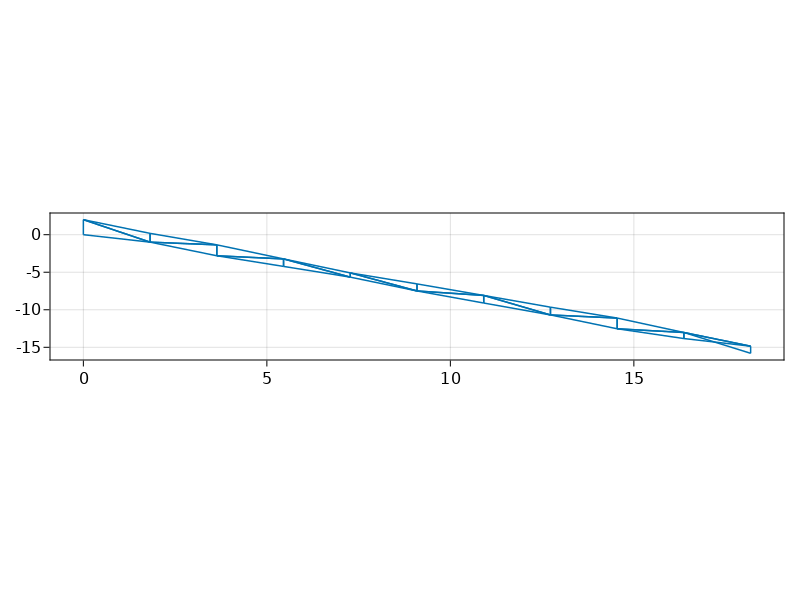

In [99]:
fig, ax, ob = wireframe(sg)
x_vals = [p[1] for p in sg[:point]]
y_vals = [p[2] for p in sg[:point]]
x_range = maximum(x_vals) - minimum(x_vals)
y_range = maximum(y_vals) - minimum(y_vals)
ax.aspect = AxisAspect(5/1)
fig